# Twitter Sentiment Analysis for ChatGPT After Release of GPT-4

This project is a fork from @Anil on Kaggle. The project is based on close to 100,000 tweets containing "GPT" scraped between 2023-03-17 and 2023-03-21 after the release of GPT-4 (kudos to avuz Kömeçoğlu and MoreThan101). (source: https://github.com/yavuzKomecoglu/twitter-sentiment-analysis-morethan101)  

The scraping was done using "snscrape" library which has stopped working on Twitter site at the time of writing (20/5/2023) as Twitter has blocked the APIs to do so. No other alternative Twitter scraping methods have been found at the time of writing.

Variables:
- ID: unique tweet id
- Date: date the tweet was sent
- Username: username of the person who tweeted (masked for this data and non-real ids are generated)
- Tweet: content of the tweet (tags and links deleted)
- ReplyCount: number of replies to tweets
- RetweetCount: number of retweets to tweets
- LikeCount: number of likes to tweets
- QuotesCount: number of quotes to tweets


## Getting Started

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
sns.set()
import calendar

import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig, pipeline
from scipy.special import softmax
import re
import emoji
from tqdm.notebook import tqdm

# Set display options
pd.set_option('display.float_format', '{:.4f}'.format)

import warnings
warnings.filterwarnings('ignore')

path = '/kaggle/input/tweets-about-chatgpt-march-2023/'
fontpath = '/kaggle/input/noto-sans-simplified-chinese-otf-files/'

# Specify the font file path for the desired Chinese font
chinese_font_path = fontpath+'NotoSansSC-Black.otf'  # Replace with the actual font file path

# Load the Chinese font
chinese_font = fm.FontProperties(fname=chinese_font_path)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Import data
df = pd.read_csv(path+'chatgpt-tweets-data-20230310-20230322.csv')
df.head()

,ID,Date,Username,Tweet,ReplyCount,RetweetCount,LikeCount,QuoteCount
0,1638329623946878976,2023-03-21 23:59:55+00:00,lqgds36373,ChatGPT is another woke machine.,4,4,32,0
1,1638329621581275136,2023-03-21 23:59:55+00:00,yxwec12342,"of the Atlantic, or only near the Atla #推特账号 m...",0,0,0,0
2,1638329600471171074,2023-03-21 23:59:50+00:00,cwsea23772,This thread is saved to your Notion database....,0,0,0,0
3,1638329587133194240,2023-03-21 23:59:46+00:00,jerje51666,Prompt AI – ChatGPT #0018,1,0,0,0
4,1638329567759802368,2023-03-21 23:59:42+00:00,wwxly15746,Just had some interesting conversations with G...,1,0,0,0


In [3]:
print("Number of unique tweets: ", df.shape[0])

Number of unique tweets:  98759


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98759 entries, 0 to 98758
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            98759 non-null  int64 
 1   Date          98759 non-null  object
 2   Username      98759 non-null  object
 3   Tweet         98759 non-null  object
 4   ReplyCount    98759 non-null  int64 
 5   RetweetCount  98759 non-null  int64 
 6   LikeCount     98759 non-null  int64 
 7   QuoteCount    98759 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 6.0+ MB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,98759.0000,1637481406058415616.0000,563281176533013.5000,1636521747540242432.0000,1636926715759888384.0000,1637527761219645440.0000,1637975215293546496.0000,1638329623946878976.0000
ReplyCount,98759.0000,1.3467,32.8560,0.0000,0.0000,0.0000,1.0000,4984.0000
RetweetCount,98759.0000,1.3948,35.9637,0.0000,0.0000,0.0000,0.0000,4076.0000
LikeCount,98759.0000,9.7873,245.5766,0.0000,0.0000,0.0000,2.0000,36112.0000
QuoteCount,98759.0000,0.2590,19.7567,0.0000,0.0000,0.0000,0.0000,5415.0000


In [6]:
# Adding time-related columns
df['Date'] = pd.to_datetime(df['Date'])
df['Date_'] = pd.to_datetime(df['Date']).dt.date
df['Time'] = df['Date'].dt.time
df['Hour'] = df['Date'].dt.hour
df['Day'] = df['Date'].dt.strftime('%A')

df['TweetStr'] = df['Tweet'].astype(str)

# Add column for hashtags
df['hashtags'] = df['TweetStr'].apply(lambda x: re.findall(r"#(\w+)", x))
df1 = df.copy()

In [7]:
df.head()

,ID,Date,Username,Tweet,ReplyCount,RetweetCount,LikeCount,QuoteCount,Date_,Time,Hour,Day,TweetStr,hashtags
0,1638329623946878976,2023-03-21 23:59:55+00:00,lqgds36373,ChatGPT is another woke machine.,4,4,32,0,2023-03-21,23:59:55,23,Tuesday,ChatGPT is another woke machine.,[]
1,1638329621581275136,2023-03-21 23:59:55+00:00,yxwec12342,"of the Atlantic, or only near the Atla #推特账号 m...",0,0,0,0,2023-03-21,23:59:55,23,Tuesday,"of the Atlantic, or only near the Atla #推特账号 m...",[推特账号]
2,1638329600471171074,2023-03-21 23:59:50+00:00,cwsea23772,This thread is saved to your Notion database....,0,0,0,0,2023-03-21,23:59:50,23,Tuesday,This thread is saved to your Notion database....,[]
3,1638329587133194240,2023-03-21 23:59:46+00:00,jerje51666,Prompt AI – ChatGPT #0018,1,0,0,0,2023-03-21,23:59:46,23,Tuesday,Prompt AI – ChatGPT #0018,[0018]
4,1638329567759802368,2023-03-21 23:59:42+00:00,wwxly15746,Just had some interesting conversations with G...,1,0,0,0,2023-03-21,23:59:42,23,Tuesday,Just had some interesting conversations with G...,[]


In [8]:
df['Date_'].value_counts().sort_index()

2023-03-17    22923
2023-03-18    14785
2023-03-19    15187
2023-03-20    20790
2023-03-21    25074
Name: Date_, dtype: int64

### Number of tweets for each day

## Explore the data

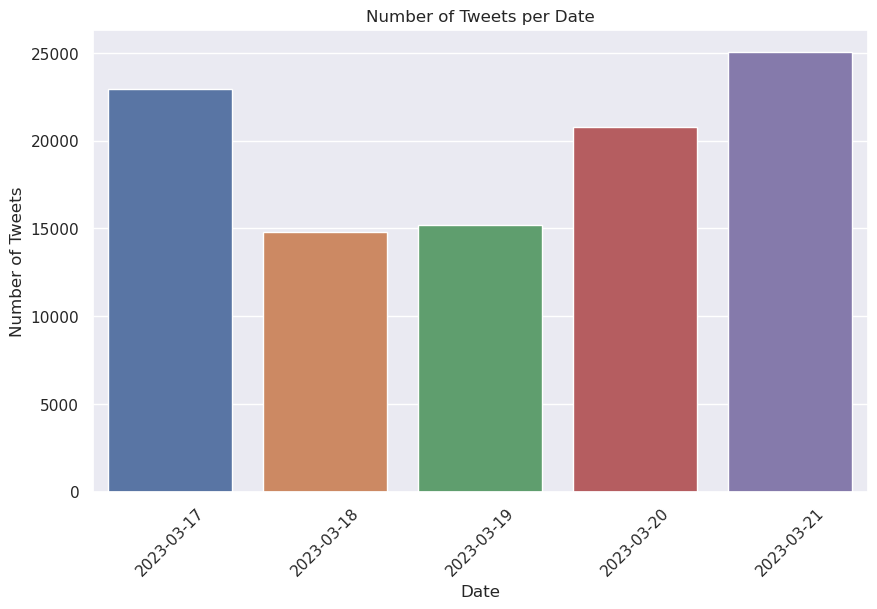

In [9]:
# Assuming your DataFrame is named 'df'
tweet_counts = df['Date_'].value_counts().sort_index()

# Plotting the number of tweets per date
plt.figure(figsize=(10, 6))
# tweet_counts.plot(kind='bar')
sns.barplot(x=tweet_counts.index, y=tweet_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets per Date')
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability
plt.show()

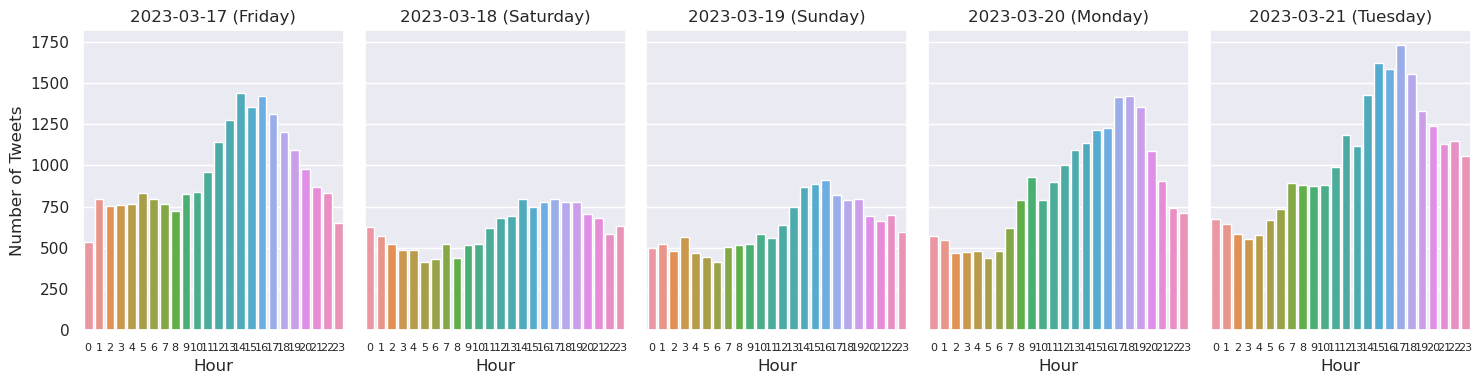

In [10]:
# Sort the dates in ascending order
dates = sorted(df['Date_'].unique())

# Set up the subplots
fig, axes = plt.subplots(1, len(dates), figsize=(15, 4), sharey=True)

# Iterate over the dates and create a bar chart for each day
for i, date in enumerate(dates):
    ax = axes[i]  # Get the appropriate subplot axes
    data = df[df['Date_'] == date]['Hour'].value_counts().sort_index()
    sns.barplot(x=data.index, y=data.values, ax=ax)
    ax.set_xlabel('Hour')
    ax.set_title(f'{date} ({calendar.day_name[date.weekday()]})')
    ax.tick_params(axis='x', labelsize=8)  # Set x-axis label font size

    if i == 0:
        ax.set_ylabel('Number of Tweets')

# Adjust the spacing between subplots
fig.tight_layout()

# Display the plots
plt.show()

## Preprocessing for Model

### Loading Twitter-roBERTa-base model for Sentiment Analysis
Source: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest

In [11]:
# load model and tokenizer
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# create pipeline
sa = pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### See some results

In [12]:
# Test run the model

index = 1042
print(df.loc[index].Tweet)
p = sa(df.loc[index].Tweet)
print(p)

You can’t ask #ChatGPT to un-fail a bank!
[{'label': 'negative', 'score': 0.6143856644630432}]


In [13]:
# Test run the model

index = 7222
print(df.loc[index].Tweet)
p = sa(df.loc[index].Tweet)
print(p)

rs and backwoodsmen. If inoffensive people were #推特账号 ith indignation in their graves, was fo 
[{'label': 'negative', 'score': 0.7818105220794678}]


### Further preprocess the tweets for labelling and scoring
*kudos to @Anil for the neat function*

In [14]:
def preprocess_word(word):
    # Remove punctuation
    #word = word.strip('\'"?!,.():;')
    
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word


def is_valid_word(word):
    # Check if word begins with an alphabet
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)


def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)|😉', ' EMO_POS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)
    return tweet


def remove_emoji(tweet):
    return emoji.replace_emoji(tweet, replace=" ")


def preprocess_tweet(tweet):
    processed_tweet = []
    # Convert to lower case
    tweet = tweet.lower()
    
    #Clean only digits
    tweet = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", tweet)
    
    # Replaces URLs with the word URL
    #tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', tweet)
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', '', tweet)
    
    # Replace @handle with the word USER_MENTION
    #tweet = re.sub(r'@[\S]+', 'USER_MENTION', tweet)
    tweet = re.sub(r'@[\S]+', '', tweet)
    
    # Replaces #hashtag with hashtag
    #tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
    tweet = re.sub(r'#(\S+)', '', tweet)
    
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', '', tweet)
    
    # Replace 2+ dots with space
    tweet = re.sub(r'\.{2,}', ' ', tweet)
    
    # Strip space, " and ' from tweet
    tweet = tweet.strip(' "\'')

    # Replace emojis with either EMO_POS or EMO_NEG
    #tweet = handle_emojis(tweet)

    #remove emojis
    tweet = remove_emoji(tweet)
    
    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)
    words = tweet.split()

    for word in words:
        word = preprocess_word(word)
        processed_tweet.append(word)

    return ' '.join(processed_tweet)

In [15]:
df["processed_tweet"] = df["Tweet"].apply(preprocess_tweet)
df.head()

,ID,Date,Username,Tweet,ReplyCount,RetweetCount,LikeCount,QuoteCount,Date_,Time,Hour,Day,TweetStr,hashtags,processed_tweet
0,1638329623946878976,2023-03-21 23:59:55+00:00,lqgds36373,ChatGPT is another woke machine.,4,4,32,0,2023-03-21,23:59:55,23,Tuesday,ChatGPT is another woke machine.,[],chatgpt is another woke machine.
1,1638329621581275136,2023-03-21 23:59:55+00:00,yxwec12342,"of the Atlantic, or only near the Atla #推特账号 m...",0,0,0,0,2023-03-21,23:59:55,23,Tuesday,"of the Atlantic, or only near the Atla #推特账号 m...",[推特账号],"of the atlantic, or only near the atla more to..."
2,1638329600471171074,2023-03-21 23:59:50+00:00,cwsea23772,This thread is saved to your Notion database....,0,0,0,0,2023-03-21,23:59:50,23,Tuesday,This thread is saved to your Notion database....,[],this thread is saved to your notion database. ...
3,1638329587133194240,2023-03-21 23:59:46+00:00,jerje51666,Prompt AI – ChatGPT #0018,1,0,0,0,2023-03-21,23:59:46,23,Tuesday,Prompt AI – ChatGPT #0018,[0018],prompt ai – chatgpt
4,1638329567759802368,2023-03-21 23:59:42+00:00,wwxly15746,Just had some interesting conversations with G...,1,0,0,0,2023-03-21,23:59:42,23,Tuesday,Just had some interesting conversations with G...,[],just had some interesting conversations with g...


## Sentiment Analysis

In [16]:
'''
df["sentiment_label"] = "-"
df["sentiment_score"] = -1

df_part_1 = df[:25000]
df_part_2 = df[25000:50000]
df_part_3 = df[50000:75000]
df_part_4 = df[75000:]

df_part_1[["sentiment_label", "sentiment_score"]] = df_part_1["processed_tweet"].progress_apply(get_sentiment_analysis) #1 hours 6 minutes
df_part_2[["sentiment_label", "sentiment_score"]] = df_part_2["processed_tweet"].progress_apply(get_sentiment_analysis) #1 hours 3 minutes
df_part_3[["sentiment_label", "sentiment_score"]] = df_part_3["processed_tweet"].progress_apply(get_sentiment_analysis) #1 hours 3 minutes
df_part_4[["sentiment_label", "sentiment_score"]] = df_part_4["processed_tweet"].progress_apply(get_sentiment_analysis) # 59 minutes

df_sa = pd.concat([df_part_1, df_part_2, df_part_3, df_part_4], axis=0)
df_sa.to_csv('chatgpt-tweets-data-20230310-20230322-processed.csv', index=False)
'''

# As experienced by @Anil the process will take hours, he has conveniently done that and the post-processed file will be imported directly in this notebook

df = pd.read_csv(path+"chatgpt-tweets-data-20230310-20230322-processed.csv")
df = pd.concat([df,df1['hashtags'],df1['Time']], axis=1)
df.head()

,ID,Date,Username,Tweet,ReplyCount,RetweetCount,LikeCount,QuoteCount,OnlyDate,OnlyHour,OnlyMin,processed_tweet,sentiment_label,sentiment_score,hashtags,Time
0,1638329623946878976,2023-03-21 23:59:55+00:00,lqgds36373,ChatGPT is another woke machine.,4,4,32,0,2023-03-21,23,59,chatgpt is another woke machine.,negative,0.8628,[],23:59:55
1,1638329621581275136,2023-03-21 23:59:55+00:00,yxwec12342,"of the Atlantic, or only near the Atla #推特账号 m...",0,0,0,0,2023-03-21,23,59,"of the atlantic, or only near the atla more to...",neutral,0.8373,[推特账号],23:59:55
2,1638329600471171074,2023-03-21 23:59:50+00:00,cwsea23772,This thread is saved to your Notion database....,0,0,0,0,2023-03-21,23,59,this thread is saved to your notion database. ...,neutral,0.8854,[],23:59:50
3,1638329587133194240,2023-03-21 23:59:46+00:00,jerje51666,Prompt AI – ChatGPT #0018,1,0,0,0,2023-03-21,23,59,prompt ai – chatgpt,neutral,0.8958,[0018],23:59:46
4,1638329567759802368,2023-03-21 23:59:42+00:00,wwxly15746,Just had some interesting conversations with G...,1,0,0,0,2023-03-21,23,59,just had some interesting conversations with g...,positive,0.9558,[],23:59:42


### Bar Plot of Sentiment Label Distribution


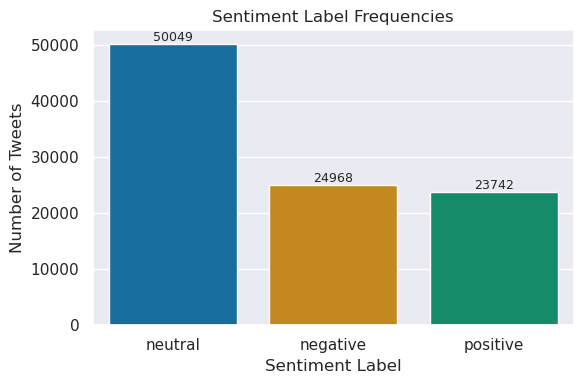

In [17]:
# Count the frequency of each sentiment label
sentiment_counts = df['sentiment_label'].value_counts()

sns.set(style="darkgrid", palette="colorblind")

# Create a column plot
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, ax=ax)

# Set the plot title and axis labels
ax.set_title('Sentiment Label Frequencies')
ax.set_xlabel('Sentiment Label')
ax.set_ylabel('Number of Tweets')

# Rotate x-axis labels upright
plt.xticks(rotation='horizontal')

# Add data labels to the top of each column
for i, freq in enumerate(sentiment_counts):
    ax.text(i, freq, str(freq), ha='center', va='bottom', fontsize=9)

# Display the plot
plt.tight_layout()
plt.show()


### Bar Plot of Sentiment Label Distribution Over Time

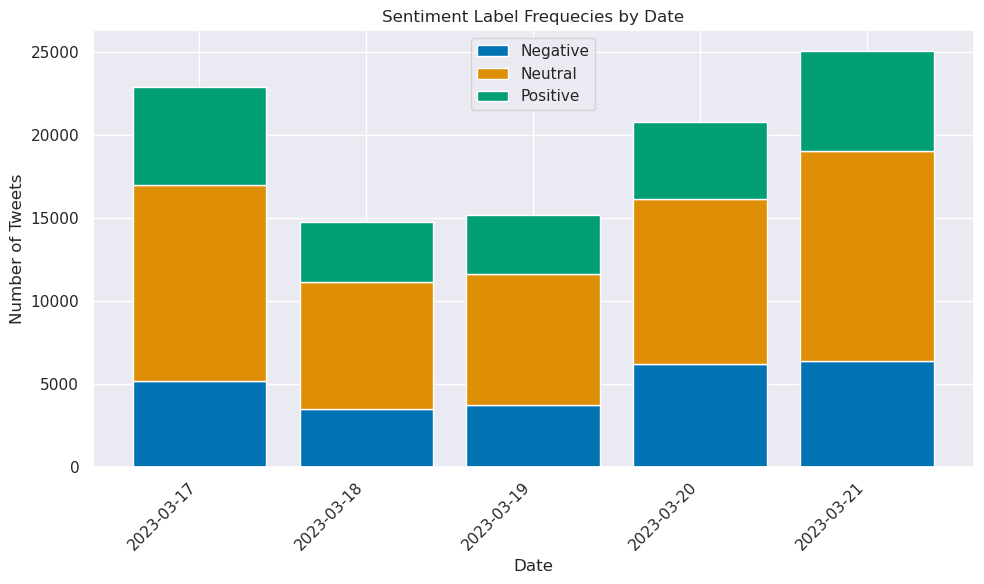

In [18]:
# Pivot table to get the count of sentiment labels for each date
pivoted_df = pd.pivot_table(df[["OnlyDate", "sentiment_label"]], index='OnlyDate', columns='sentiment_label', aggfunc=len, fill_value=0)

sns.set(style="darkgrid", palette="colorblind")
fig, ax = plt.subplots(figsize=(10, 6))
negative_bars = ax.bar(pivoted_df.index.values, pivoted_df['negative'], label='Negative')
neutral_bars = ax.bar(pivoted_df.index.values, pivoted_df['neutral'], bottom=pivoted_df['negative'], label='Neutral')
positive_bars = ax.bar(pivoted_df.index.values, pivoted_df['positive'], bottom=pivoted_df['neutral']+pivoted_df['negative'], label='Positive')

ax.set_xlabel('Date')
ax.set_ylabel('Number of Tweets')
ax.set_title('Sentiment Label Frequecies by Date')

fig.autofmt_xdate(rotation=45)

ax.legend(loc='upper center')

# Show the plot
plt.tight_layout()
plt.show()

### Dive into each sentiment label and see the WordCloud

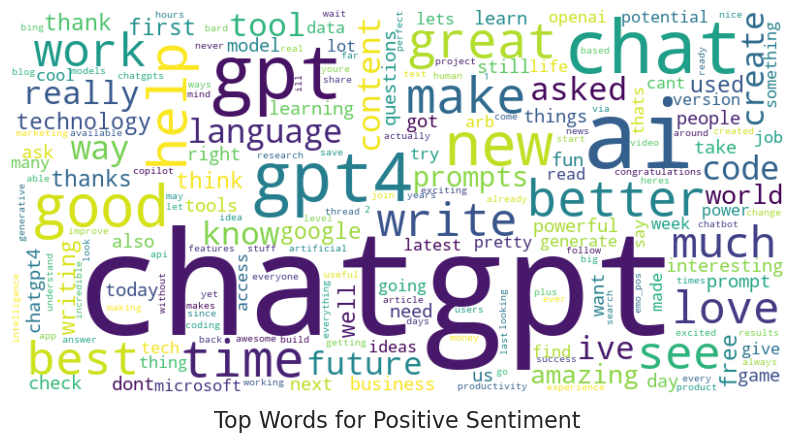

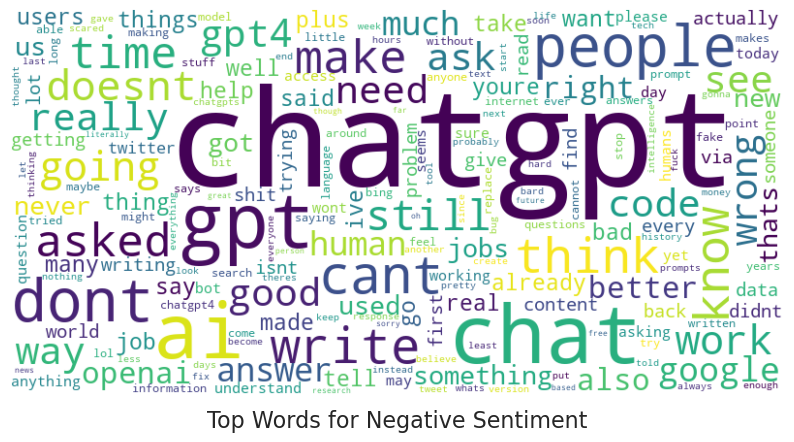

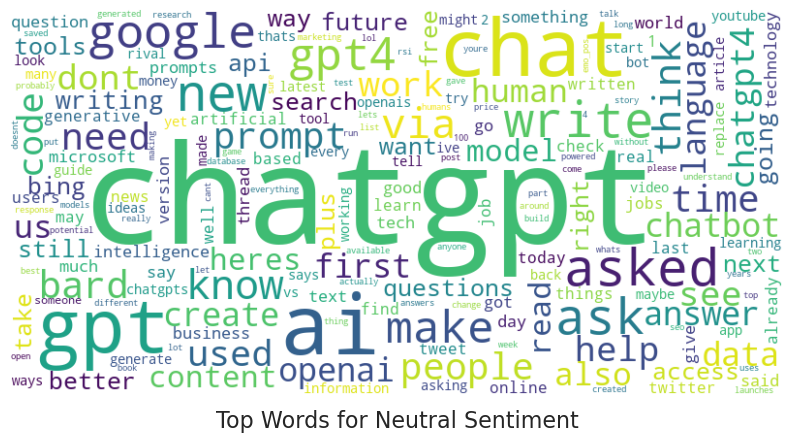

In [19]:
# Seperate dataframes according to sentiment labels

df_positive = df[df["sentiment_label"] == "positive"]
df_neutral = df[df["sentiment_label"] == "neutral"]
df_negative = df[df["sentiment_label"] == "negative"]

from collections import Counter

def get_top_words(df, col, num_words, exclude_words):
    word_counts = Counter()
    for text in df[col]:
        if isinstance(text, str):  # Check if text is a valid string
            words = text.lower().split()
            words = [word for word in words if word not in exclude_words]
            word_counts.update(words)
    top_words = word_counts.most_common(num_words)
    return top_words


def wordcloudplot(df, col, nos, title):
    df[col] = df[col].str.replace('[^\w\s]', '')
    stopwords_list = stopwords.words('english')
    additional_exclude_words = ['like',"n't",'use','using','get','one','amp','could','would','im','even']
    exclude_words = set(stopwords_list + additional_exclude_words)
    top_words = get_top_words(df, col, nos, exclude_words)
    wordcloud = WordCloud(width=800, 
                          height=400,
                          contour_width=3,
                          contour_color='midnightblue', 
                          background_color="white").generate_from_frequencies(dict(top_words))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16, pad=20, y=-0.15)  # Adjust the title position and text size
    plt.show()
    
wordcloudplot(df_positive, "processed_tweet", 500, "Top Words for Positive Sentiment")
wordcloudplot(df_negative, "processed_tweet", 500, "Top Words for Negative Sentiment")
wordcloudplot(df_neutral, "processed_tweet", 500, "Top Words for Neutral Sentiment")

### Line plot of Average Sentiment Over Time

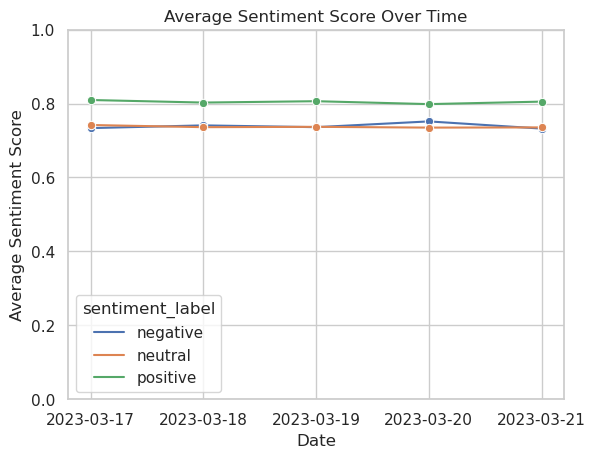

In [20]:
df_avg_sentiment = df.groupby(['OnlyDate', 'sentiment_label'])['sentiment_score'].mean().reset_index()
sns.set(style='whitegrid')
sns.lineplot(data=df_avg_sentiment, x='OnlyDate', y='sentiment_score', hue='sentiment_label', marker='o')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score Over Time')
plt.ylim(0, 1)
plt.show()

### Scatterplot Between LikeCount and RetweetCount

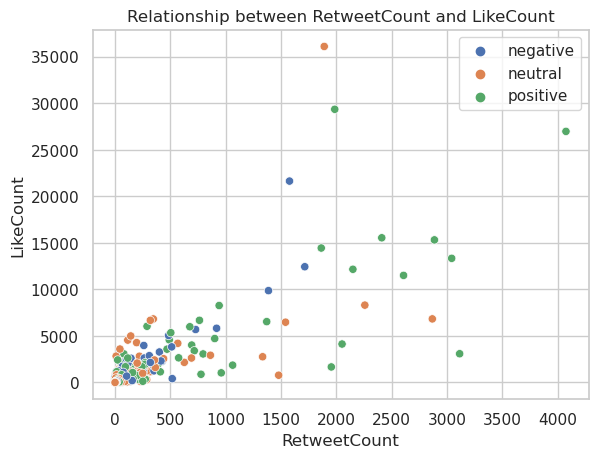

In [21]:
sns.scatterplot(data=df, x='RetweetCount', y='LikeCount', hue='sentiment_label')
plt.title('Relationship between RetweetCount and LikeCount')
plt.xlabel('RetweetCount')
plt.ylabel('LikeCount')
plt.legend()
plt.show()

### Hashtags Popularity

In [22]:
from collections import Counter

# Flatten the arrays of hashtags into a single list
hashtags_list = np.concatenate(df['hashtags'].values)

# Count the occurrences of each hashtag
hashtags_counter = Counter(hashtags_list)

# Get the top hashtags
top_hashtags = hashtags_counter.most_common(30)

# Create a DataFrame from the top hashtags data
top_hashtags_df = pd.DataFrame(top_hashtags, columns=['Hashtag', 'Count'])

# Add columns for sentiment label breakdown
top_hashtags_df['Positive'] = 0
top_hashtags_df['Neutral'] = 0
top_hashtags_df['Negative'] = 0

# Iterate over the DataFrame and update the counts for each sentiment label
for i, row in top_hashtags_df.iterrows():
    hashtag = row['Hashtag']
    positive_count = df.loc[(df['sentiment_label'] == 'positive') & (df['hashtags'].apply(lambda x: hashtag in x))].shape[0]
    neutral_count = df.loc[(df['sentiment_label'] == 'neutral') & (df['hashtags'].apply(lambda x: hashtag in x))].shape[0]
    negative_count = df.loc[(df['sentiment_label'] == 'negative') & (df['hashtags'].apply(lambda x: hashtag in x))].shape[0]
    top_hashtags_df.loc[i, 'Positive'] = positive_count
    top_hashtags_df.loc[i, 'Neutral'] = neutral_count
    top_hashtags_df.loc[i, 'Negative'] = negative_count

# Display the top hashtags DataFrame
display(top_hashtags_df)

,Hashtag,Count,Positive,Neutral,Negative
0,ChatGPT,15796,5239,7615,2703
1,AI,5471,2101,2549,621
2,chatgpt,3206,957,1792,438
3,推特账号,2082,137,1351,594
4,GPT4,2062,877,787,298
5,ai,1646,508,928,198
6,openai,1433,548,594,245
7,chatgpt4,1393,437,708,244
8,ArtificialIntelligence,1123,346,646,130
9,NFT,908,658,160,89


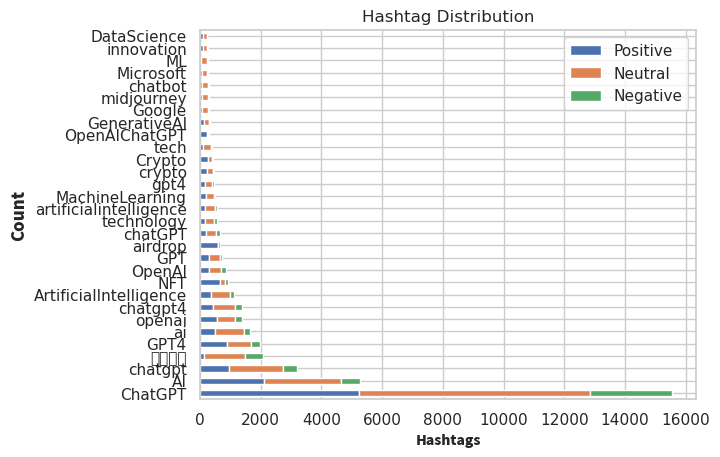

In [23]:
# Exclude the 'Count' column
plot_data = top_hashtags_df.drop('Count', axis=1)

# Set the 'Hashtag' column as the index
plot_data.set_index('Hashtag', inplace=True)

# Plot the bar chart
plot_data.plot(kind='barh', stacked=True)

# Set the labels and title
plt.xlabel('Hashtags', fontsize=10, fontproperties=chinese_font)
plt.ylabel('Count', fontproperties=chinese_font)
plt.title('Hashtag Distribution')

# Show the plot
plt.show()

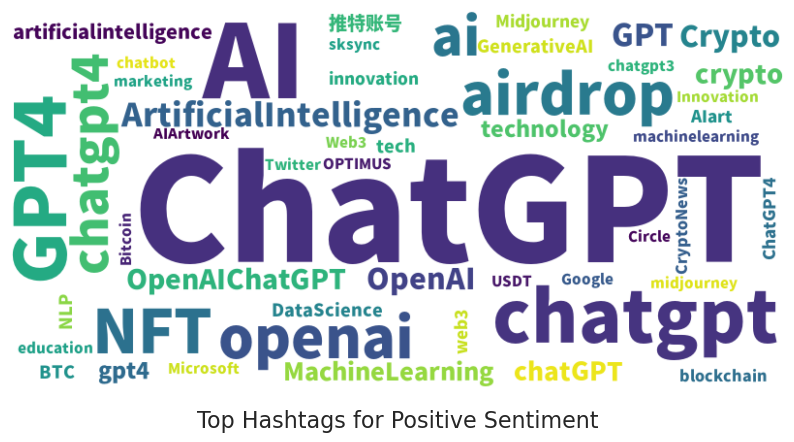

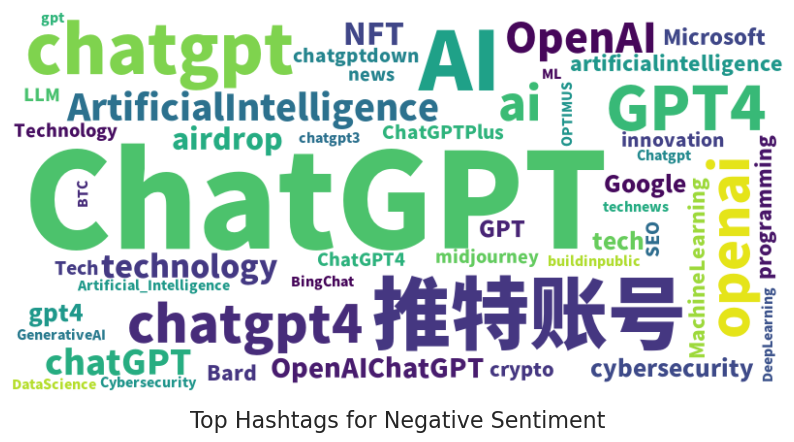

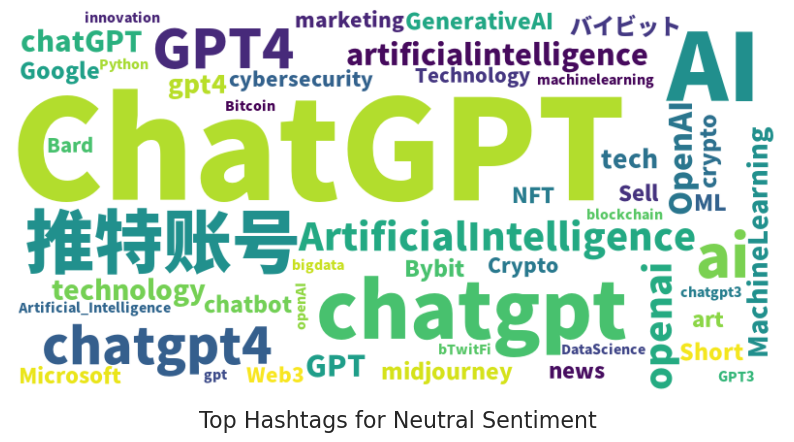

In [24]:
import ast

def wordcloudplot2(df, col, nos, title):
    # Concatenate all hashtags into a single string and remove missing values
    hashtags_string = ' '.join(df[col].explode().astype(str))
    hashtags_string = hashtags_string.replace('nan', '')
    
    # Count the frequency of each hashtag
    hashtag_counts = Counter(hashtags_string.split())
    
    stopwords_list = stopwords.words('english')
    additional_exclude_words = ['like', "n't", 'use', 'using', 'get', 'one', 'amp', 'could', 'would', 'im', 'even']
    exclude_words = set(stopwords_list + additional_exclude_words)
    
    # Get the top 'nos' most frequent hashtags
    top_hashtags = dict(hashtag_counts.most_common(nos))
    
    # Generate the word cloud from the top hashtags, specifying the font for non-Latin characters
    wordcloud = WordCloud(width=800,
                          height=400,
                          contour_width=3,
                          contour_color='midnightblue',
                          background_color="white",
                          stopwords=exclude_words,
                          font_path=fontpath+'NotoSansSC-Black.otf').generate_from_frequencies(top_hashtags)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16, pad=20, y=-0.15)  # Adjust the title position and text size
    plt.show()
    
wordcloudplot2(df_positive, "hashtags", 50, "Top Hashtags for Positive Sentiment")
wordcloudplot2(df_negative, "hashtags", 50, "Top Hashtags for Negative Sentiment")
wordcloudplot2(df_neutral, "hashtags", 50, "Top Hashtags for Neutral Sentiment")